<a href="https://colab.research.google.com/github/maxburton/lvl4-ml-coursework/blob/classification/CM_SVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Normalizer, LabelBinarizer, StandardScaler

from sklearn.base import clone

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFromModel, mutual_info_classif
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score, roc_auc_score, accuracy_score
from sklearn.decomposition import PCA

from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Load data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp drive/My\ Drive/Colab\ Notebooks/ML/X_train.csv .
!cp drive/My\ Drive/Colab\ Notebooks/ML/y_train.csv .
!cp drive/My\ Drive/Colab\ Notebooks/ML/X_test.csv .

In [0]:
X_test = pd.read_csv("X_test.csv")
X_train = pd.read_csv("X_train.csv")

# Subtract 1 to normalize labels to 0,1
y_train = pd.read_csv("y_train.csv")["EpiOrStroma"] - 1

# Remove columns 17 and 85, as they are (nearly) constant
drops = [X_train.columns[85], X_train.columns[17]]

X_test = X_test.drop(drops, axis=1)
X_train = X_train.drop(drops, axis=1)

## Helpers

In [0]:
def grid_search(model, parameters, X_train, y_train, cv=10):
    gs = GridSearchCV(model, parameters, cv=cv, iid=False, scoring="f1")
    gs.fit(X_train, y_train)

    result = pd.DataFrame(gs.cv_results_).sort_values(by=["mean_test_score"], ascending=False)

    params = result.params.reset_index().head(1).to_dict()["params"][0]
    return params, gs.best_estimator_


def save_output(model, X_test):
    y_pred = model.predict(X_test)
    submission = pd.DataFrame({'Id': pd.read_csv("X_test.csv").index, 'EpiOrStroma': y_pred + 1})
    submission.to_csv('submission.csv', index=False)


def plot_roc(y_true, y_pred, ax=plt):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    ax.plot(fpr, tpr)
    ax.set_xlabel("1 - Specificity")
    ax.set_ylabel("Sensitivity")
    return roc_auc_score(y_true, y_pred)


def cv_eval(model_, X, y, n_splits=10):
    X = X.to_numpy()
    y = y.to_numpy()
    fig, ax = plt.subplots(1, figsize=(4, 4))

    acc = []
    f1 = []
    auc = []
    cv = StratifiedKFold(n_splits=n_splits)
    for train_index, test_index in cv.split(X, y):
        model = clone(model_)
        X_tr, X_te = X[train_index], X[test_index]
        y_tr, y_te = y[train_index], y[test_index]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        acc.append(accuracy_score(y_te, y_pred))
        f1.append(f1_score(y_te, y_pred))
        auc.append(roc_auc_score(y_te, y_pred))
    plot_roc(y, model.predict_proba(X)[:,1], ax=ax)

    def mean(l):
        return sum(l)/len(l)

    print(f"Acc: {mean(acc)},\nF1: {mean(f1)},\nAUC: {mean(auc)}\n")

## Models

### Just classifier

Params: {'clas__C': 0.1, 'clas__gamma': 0.1}

Acc: 0.5550156347717323,
F1: 0.7138187466948704,
AUC: 0.5



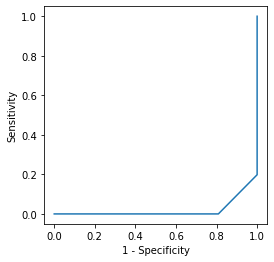

In [79]:
k = 5

model = Pipeline([
    ("clas", SVC(gamma="auto", probability=True)),
])

parameters = {
    "clas__C": [0.1, 0.5, 1, 10, 100],
    "clas__gamma": [0.1, 1, 10],
}

params, best = grid_search(model, parameters, X_train, y_train, cv=k)
print(f"Params: {params}\n")

cv_eval(best, X_train, y_train, n_splits=k)

### With scaling and normalization

Params: {'clas__C': 0.1, 'clas__gamma': 1}

Acc: 0.8297248280175111,
F1: 0.847992165881933,
AUC: 0.8237864579296804



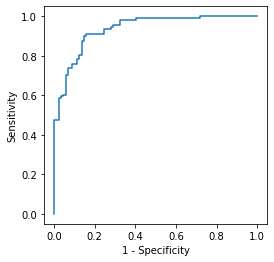

In [80]:
k = 5

model = Pipeline([
    ("scal", StandardScaler()),
    ("norm", Normalizer()),
    ("clas", SVC(gamma="auto", probability=True)),
])

parameters = {
    "clas__C": [0.1, 0.5, 1, 10, 100],
    "clas__gamma": [0.1, 1, 10],
}

params, best = grid_search(model, parameters, X_train, y_train, cv=k)
print(f"Params: {params}\n")

cv_eval(best, X_train, y_train, n_splits=k)

### With feature selection

Params: {'clas__C': 0.5, 'clas__gamma': 1, 'selector__k': 11, 'selector__score_func': <function f_classif at 0x7fddaa2bf8c8>}

Acc: 0.854731081926204,
F1: 0.8601292851292852,
AUC: 0.8547237076648841



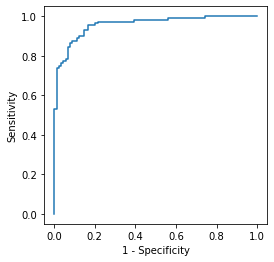

In [81]:
k = 5

model = Pipeline([
    ("selector", SelectKBest(k=10)),
    ("scal", StandardScaler()),
    ("norm", Normalizer()),
    ("clas", SVC(gamma="auto", probability=True)),
])

parameters = {
    "clas__C": [0.1, 0.5, 1, 10, 100],
    "clas__gamma": [0.1, 1, 10],
    "selector__k": range(10, 30),
    "selector__score_func": [f_classif],
}

params, best = grid_search(model, parameters, X_train, y_train, cv=k)
print(f"Params: {params}\n")

cv_eval(best, X_train, y_train, n_splits=k)

### With PCA instead of k best



Params: {'clas__C': 1, 'clas__gamma': 0.1, 'selector__n_components': 16}

Acc: 0.8249812382739213,
F1: 0.8487315856575188,
AUC: 0.8173499702911468



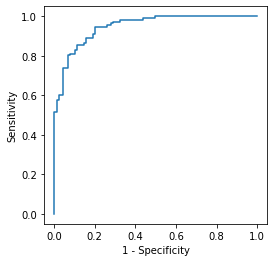

In [82]:
k = 5

model = Pipeline([
    ("selector", PCA()),
    ("scal", StandardScaler()),
    ("norm", Normalizer()),
    ("clas", SVC(gamma="auto", probability=True)),
])

parameters = {
    "clas__C": [0.1, 0.5, 1, 10, 100],
    "clas__gamma": [0.1, 1, 10],
    "selector__n_components": range(2, 20),
}

params, best = grid_search(model, parameters, X_train, y_train, cv=k)
print(f"Params: {params}\n")

cv_eval(best, X_train, y_train, n_splits=k)

### Final (feature selection + PCA)

Acc: 0.8546028767979987,
F1: 0.8600391855269904,
AUC: 0.8547237076648841

              precision    recall  f1-score   support

           0       0.84      0.85      0.84        89
           1       0.88      0.86      0.87       111

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



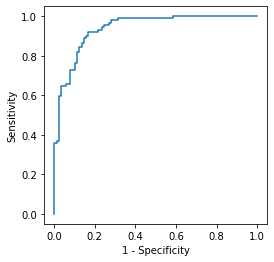

In [90]:
k = 5

model = Pipeline([               
    ("scal", StandardScaler()),
    ("norm", Normalizer()),
    ("selector", SelectKBest(k=20)),
    ("pca", PCA(n_components=3)),
    ("clas", SVC(gamma="auto", probability=True)),
])


best = model
cv_eval(best, X_train, y_train, n_splits=k)

final = clone(best)
final.fit(X_train, y_train)

save_output(final, X_test)

## Addtionally: Test with LogisticRegression

Acc: 0.854731081926204,
F1: 0.8578617481808971,
AUC: 0.8543969102792632



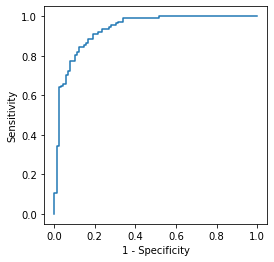

In [89]:
k = 5

model = Pipeline([
    ("scal", StandardScaler()),
    ("selector", SelectKBest(k=20)),
    ("pca", PCA(n_components=3)),
    ("clas", LogisticRegression(solver="saga", penalty="l1")),
])


best = model
cv_eval(best, X_train, y_train, n_splits=k)

final = clone(best)
final.fit(X_train, y_train)

save_output(final, X_test)

Text(0.5, 0, '3rd principal component')

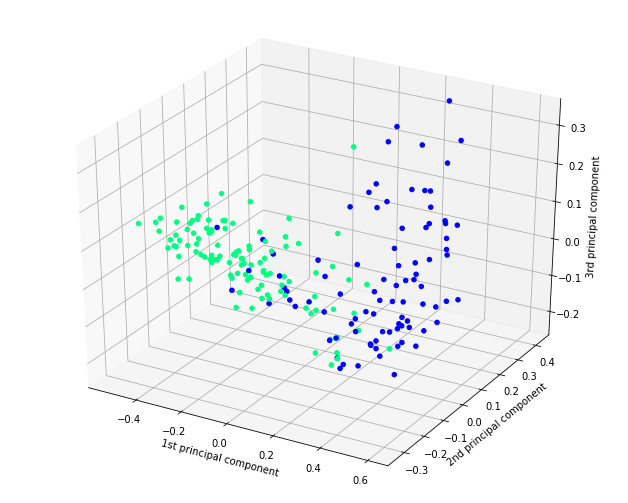

In [0]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

model = Pipeline([
    ("scal", StandardScaler()),
    ("norm", Normalizer()),
    ("selector", SelectKBest(k=20)),
    ("pca", PCA(n_components=3)),
])

test = model.fit_transform(X_train, y_train)

fig = plt.figure(figsize=(11,9))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(test[:,0], test[:,1], test[:,2], c=y_train, alpha=1, cmap="winter")
ax.set_xlabel("1st principal component")
ax.set_ylabel("2nd principal component")
ax.set_zlabel("3rd principal component")


Text(0, 0.5, '2nd principal component')

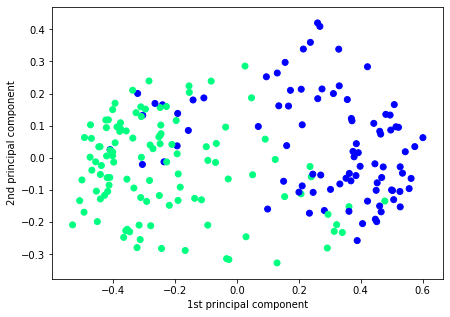

In [0]:
model = Pipeline([
    ("scal", StandardScaler()),
    ("norm", Normalizer()),
    ("selector", SelectKBest(k=20)),
    ("pca", PCA(n_components=2)),
])

test = model.fit_transform(X_train, y_train)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

ax.scatter(test[:,0], test[:,1], c=y_train, alpha=1, cmap="winter")
ax.set_xlabel("1st principal component")
ax.set_ylabel("2nd principal component")
